# Linear Regression to Predict Student Performance

Our selected dataset is [Student Performance Factors](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors).

All of the scripts and data for this project can be found on our [Git Repository](https://github.com/cztm/linear-regression).

In [325]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

import plot_settings
from plot_settings import colors

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.stats.outliers_influence import OLSInfluence

from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Student Performance Factors Dataset Overview

The "Student Performance Factors" dataset contains 19 variables that may influence students' exam scores. It is designed to help researchers analyze the potential impact of these factors on student performance. The dataset includes information such as study time (`Hours_Studied`), attendance (`Attendance`), parental involvement (`Parental_Involvement`), access to resources (`Access_to_Resources`), and participation in extracurricular activities (`Extracurricular_Activities`). Additionally, it covers socioeconomic and background data such as family income (`Family_Income`), motivation level (`Motivation_Level`), tutoring sessions (`Tutoring_Sessions`), school type (`School_Type`), sleep hours (`Sleep_Hours`), and parental education level (`Parental_Education_Level`).

## Purpose and Applications

Researchers can use this dataset to build regression models for predicting exam scores (`Exam_Score`) and to identify significant factors affecting student academic performance. The dataset's potential applications include:

- Supporting educational decision-making
- Assisting in policy formulation
- Optimizing the allocation of educational resources

Ultimately, the goal is to better understand and improve the key factors influencing student success, thereby enabling educators and policymakers to provide more targeted support.

## Variable Descriptions

1. **Hours_Studied**: Daily study hours.  
2. **Attendance**: Attendance rate (percentage).  
3. **Parental_Involvement**: Parent involvement (Low, Medium, High).  
4. **Access_to_Resources**: Resource accessibility (Low, Medium, High).  
5. **Extracurricular_Activities**: Participation in extracurricular activities.  
6. **Sleep_Hours**: Daily sleep hours.  
7. **Previous_Scores**: Prior exam scores.  
8. **Motivation_Level**: Motivation level (Low, Medium, High).  
9. **Internet_Access**: Internet access.  
10. **Tutoring_Sessions**: Number of tutoring sessions.  
11. **Family_Income**: Family income level (Low, Medium, High).  
12. **Teacher_Quality**: Teacher quality (Low, Medium, High).  
13. **School_Type**: School type (Public or Private).  
14. **Peer_Influence**: Peer influence (Positive, Neutral, Negative).  
15. **Physical_Activity**: Weekly physical activity hours.  
16. **Learning_Disabilities**: Presence of learning disabilities.  
17. **Parental_Education_Level**: Parents' education level (High School, College, Postgraduate).  
18. **Distance_from_Home**: Distance from home to school (Near, Moderate, Far).  
19. **Gender**: Student gender (Male or Female).  
20. **Exam_Score**: Academic performance indicator (exam score).

## Research Questions

1. **Which factors are the most significant predictors of students' exam scores?**
2. **How do parental involvement, access to resources, and socioeconomic factors impact student performance?**
3. **What is the combined effect of study habits, peer influence, and tutoring sessions on exam outcomes?**
4. **Does school type or teacher quality significantly influence exam scores?**

## Methods Used in the Analysis
   
1. **Exploratory Data Analysis**: Initial analysis includes correlation calculations to understand the relationships between predictors and exam scores.

2. **Multiple Linear Regression**: Regression models are built using significant predictors such as attendance, hours studied, and previous scores. The model is validated using metrics like adjusted R-squared, p-values, and F-statistics.

3. **ANOVA (Types I, II, and III)**: Variance analysis is conducted to understand the contribution of each predictor to the total variance in exam scores.

4. **Model Evaluation**: The model’s prediction capability is visualized through plots of actual vs. predicted exam scores, residuals distribution, and summary statistics.


In [282]:
students = pd.read_csv("StudentPerformanceFactors.csv")

## EDA

### First sniff of the data

In [283]:
print(f"Our dataset has {students.shape[1]} variables and {students.shape[0]} records")

Our dataset has 20 variables and 6607 records


In [284]:
students.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [285]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

### Variable types

In [286]:
object_cols = []
numeric_cols = []
for colname in students.columns:
    type = students[colname].dtype
    if type == "int64":
        numeric_cols.append(colname)
    elif type == "object":
        object_cols.append(colname)

In [287]:
print(f"Object columns: {object_cols}")
print(f"Numeric columns: {numeric_cols}")

Object columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numeric columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']


In [288]:
unique_values = students.nunique()
unique_values

Hours_Studied                 41
Attendance                    41
Parental_Involvement           3
Access_to_Resources            3
Extracurricular_Activities     2
Sleep_Hours                    7
Previous_Scores               51
Motivation_Level               3
Internet_Access                2
Tutoring_Sessions              9
Family_Income                  3
Teacher_Quality                3
School_Type                    2
Peer_Influence                 3
Physical_Activity              7
Learning_Disabilities          2
Parental_Education_Level       3
Distance_from_Home             3
Gender                         2
Exam_Score                    45
dtype: int64

Let's check that all of our object variables can be turned into categorical:

In [289]:
students[object_cols].nunique()

Parental_Involvement          3
Access_to_Resources           3
Extracurricular_Activities    2
Motivation_Level              3
Internet_Access               2
Family_Income                 3
Teacher_Quality               3
School_Type                   2
Peer_Influence                3
Learning_Disabilities         2
Parental_Education_Level      3
Distance_from_Home            3
Gender                        2
dtype: int64

Since all of them are not actually continuous or discrete values with a lot of unique values, let's go ahead and turn them info categorical variables.

In [290]:
students[object_cols] = students[object_cols].astype('category')

Let's check our resulting column types and redefine our lists.

In [291]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Hours_Studied               6607 non-null   int64   
 1   Attendance                  6607 non-null   int64   
 2   Parental_Involvement        6607 non-null   category
 3   Access_to_Resources         6607 non-null   category
 4   Extracurricular_Activities  6607 non-null   category
 5   Sleep_Hours                 6607 non-null   int64   
 6   Previous_Scores             6607 non-null   int64   
 7   Motivation_Level            6607 non-null   category
 8   Internet_Access             6607 non-null   category
 9   Tutoring_Sessions           6607 non-null   int64   
 10  Family_Income               6607 non-null   category
 11  Teacher_Quality             6529 non-null   category
 12  School_Type                 6607 non-null   category
 13  Peer_Influence    

In [292]:
categorical_variables = []
numerical_variables = []
for colname in students.columns:
    type = students[colname].dtype
    if type == "int64":
        numerical_variables.append(colname)
    elif type == "category":
        categorical_variables.append(colname)

In [293]:
print(f"Categorical variables: {categorical_variables}")
print(f"Numerical variables: {numerical_variables}")

Categorical variables: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numerical variables: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']


### Missing values
Let's take a closer look at the missing values in our dataset.

In [294]:
students.isnull().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

Let's check the actual frequency of our missing values based on the total amount of records we have.

In [295]:
students.isnull().sum()/len(students)*100

Hours_Studied                 0.000000
Attendance                    0.000000
Parental_Involvement          0.000000
Access_to_Resources           0.000000
Extracurricular_Activities    0.000000
Sleep_Hours                   0.000000
Previous_Scores               0.000000
Motivation_Level              0.000000
Internet_Access               0.000000
Tutoring_Sessions             0.000000
Family_Income                 0.000000
Teacher_Quality               1.180566
School_Type                   0.000000
Peer_Influence                0.000000
Physical_Activity             0.000000
Learning_Disabilities         0.000000
Parental_Education_Level      1.362192
Distance_from_Home            1.014076
Gender                        0.000000
Exam_Score                    0.000000
dtype: float64

The percentage of missing values we have is very very low, and since we have a considerable number of records as it is, we've decided to **drop the records with missing data**

In [296]:
students_adjusted = students.dropna()
students_adjusted.isnull().sum()

Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64

In [297]:
print(f"The original dataset, students, has {students.shape[1]} variables and {students.shape[0]} records")
print(f"We had a total of {students.shape[0]-students_adjusted.shape[0]} records with missing data.")
print(f"Our resulting dataset, adjusted_students, has {students_adjusted.shape[1]} variables and {students_adjusted.shape[0]} records")

The original dataset, students, has 20 variables and 6607 records
We had a total of 229 records with missing data.
Our resulting dataset, adjusted_students, has 20 variables and 6378 records


### First visualizations

We want to visualize our variables, and therefore will use a number of different plots. We will approach numerical and categorical variables differently.

In [298]:
print(f"Categorical variables: {categorical_variables}")
print(f"Numerical variables: {numerical_variables}")

Categorical variables: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numerical variables: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']


#### Categorical variables

##### Bar plots

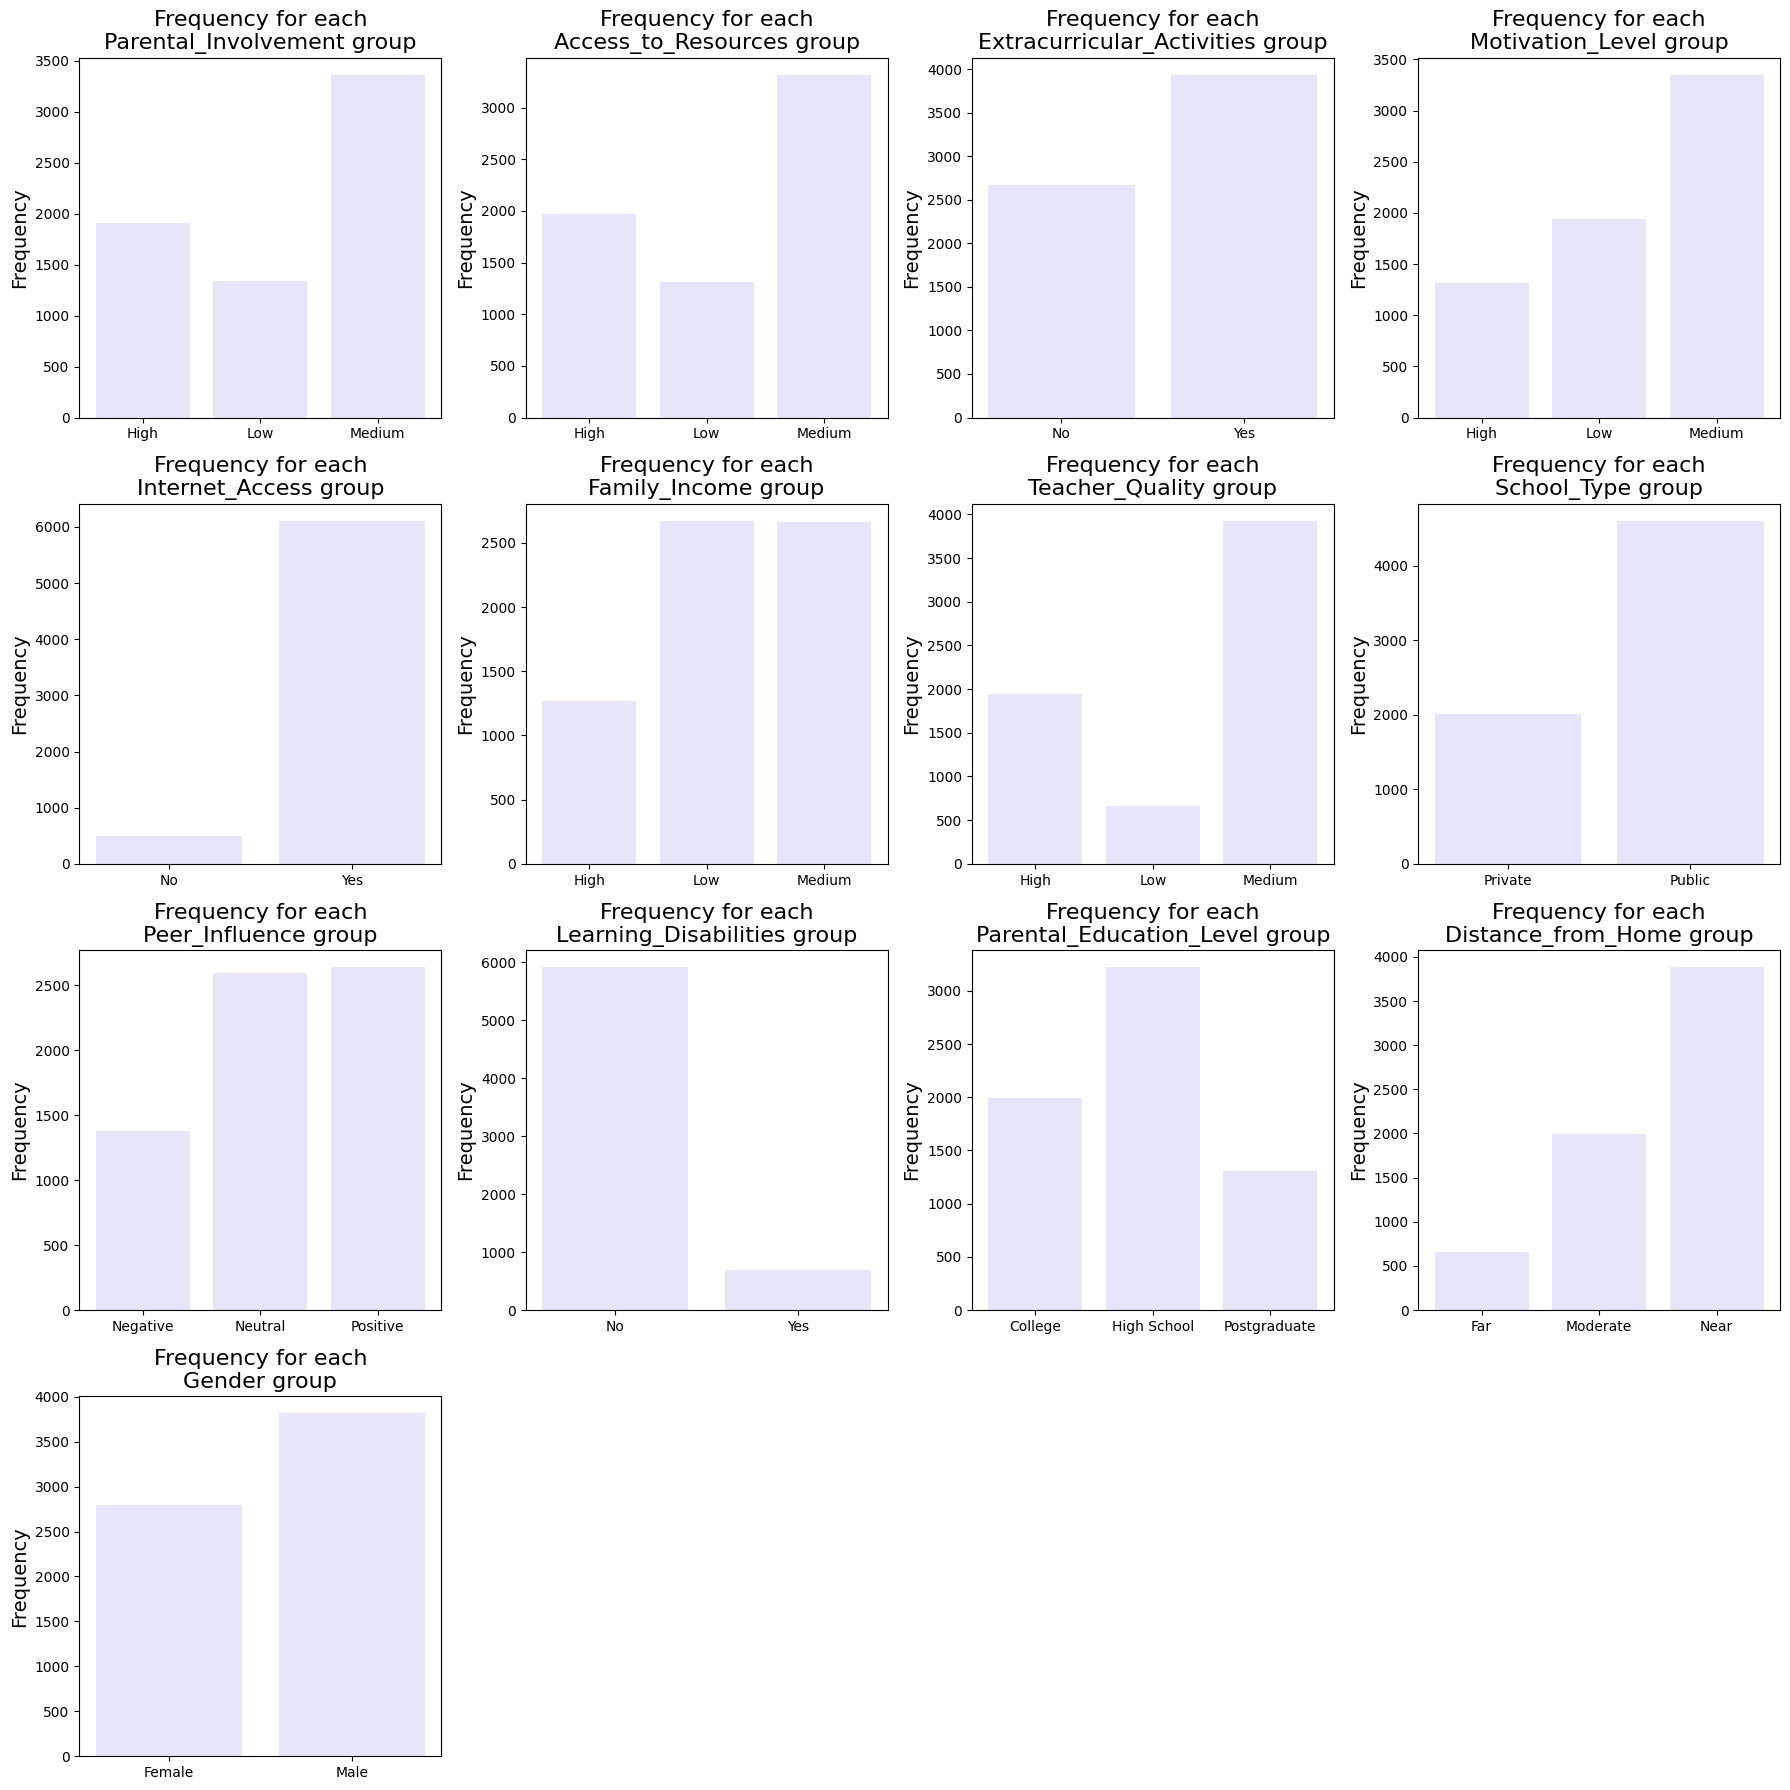

In [299]:
fig = plt.figure(figsize=(18, 18))
gs = gridspec.GridSpec(nrows=4, ncols=4)

ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax03 = fig.add_subplot(gs[0, 3])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2])
ax13 = fig.add_subplot(gs[1, 3])
ax20 = fig.add_subplot(gs[2, 0])
ax21 = fig.add_subplot(gs[2, 1])
ax22 = fig.add_subplot(gs[2, 2])
ax23 = fig.add_subplot(gs[2, 3])
ax30 = fig.add_subplot(gs[3, 0])

ax = [ax00, ax01, ax02, ax03, ax10, ax11, ax12, ax13, ax20, ax21, ax22, ax23, ax30]

for i, colname in enumerate(categorical_variables):

    group = students.groupby(colname, observed=False).size()

    ax[i].bar(group.index.astype(str), group, color='lavender')

    ax[i].set_ylabel('Frequency')
    ax[i].set_title(f"Frequency for each\n{colname} group")

plt.tight_layout()
plt.show()

##### Confusion tables

In [300]:
parent_invol_resource_access_crossed = pd.crosstab(students['Parental_Involvement'],students['Access_to_Resources'])
print(parent_invol_resource_access_crossed)

Access_to_Resources   High  Low  Medium
Parental_Involvement                   
High                   568  413     927
Low                    414  231     692
Medium                 993  669    1700


Since students who have medium/high parental involvement also have medium/high access to resources, both categories aren't necessary for the model and since access to resources matters more for our model, we'll be dropping parental involvement.

In [301]:
peer_influence_income_crossed = pd.crosstab(students['Peer_Influence'],students['Family_Income'])
print(peer_influence_income_crossed)

Family_Income   High   Low  Medium
Peer_Influence                    
Negative         251   577     549
Neutral          493  1038    1061
Positive         525  1057    1056


Since students who have medium/high family income also have neutral/positive peer relationships, both categories aren't necessary for the model and we've chosen to keep family income as it's a variable of interest.

In [302]:
distance_motivation_crossed = pd.crosstab(students['Distance_from_Home'], students['Motivation_Level'])
print(distance_motivation_crossed)

Motivation_Level    High   Low  Medium
Distance_from_Home                    
Far                  142   185     331
Moderate             394   611     993
Near                 773  1125    1986


Since students with medium/high motivation levels live moderate/near schools, both categories aren't necessary for the model and we've chosen to keep motivation levels as it's a variable of interest.

In [303]:
students = students.drop(columns=['Distance_from_Home', 'Peer_Influence', 'Parental_Involvement'])

In [304]:
students.sample(5)

,Hours_Studied,Attendance,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Gender,Exam_Score
5740,22,61,High,No,5,60,High,Yes,0,High,Low,Private,2,No,High School,Male,63
1147,11,91,Low,No,8,61,Medium,Yes,1,High,Medium,Private,3,No,Postgraduate,Male,65
352,25,77,Low,Yes,8,65,High,No,0,Medium,Medium,Public,5,No,College,Female,66
2252,11,79,Medium,No,8,71,Low,Yes,1,Medium,Medium,Private,2,No,College,Female,63
6038,25,82,High,No,8,94,Low,Yes,2,Low,Medium,Public,3,No,High School,Male,70


#### Numerical variables

##### Boxplots

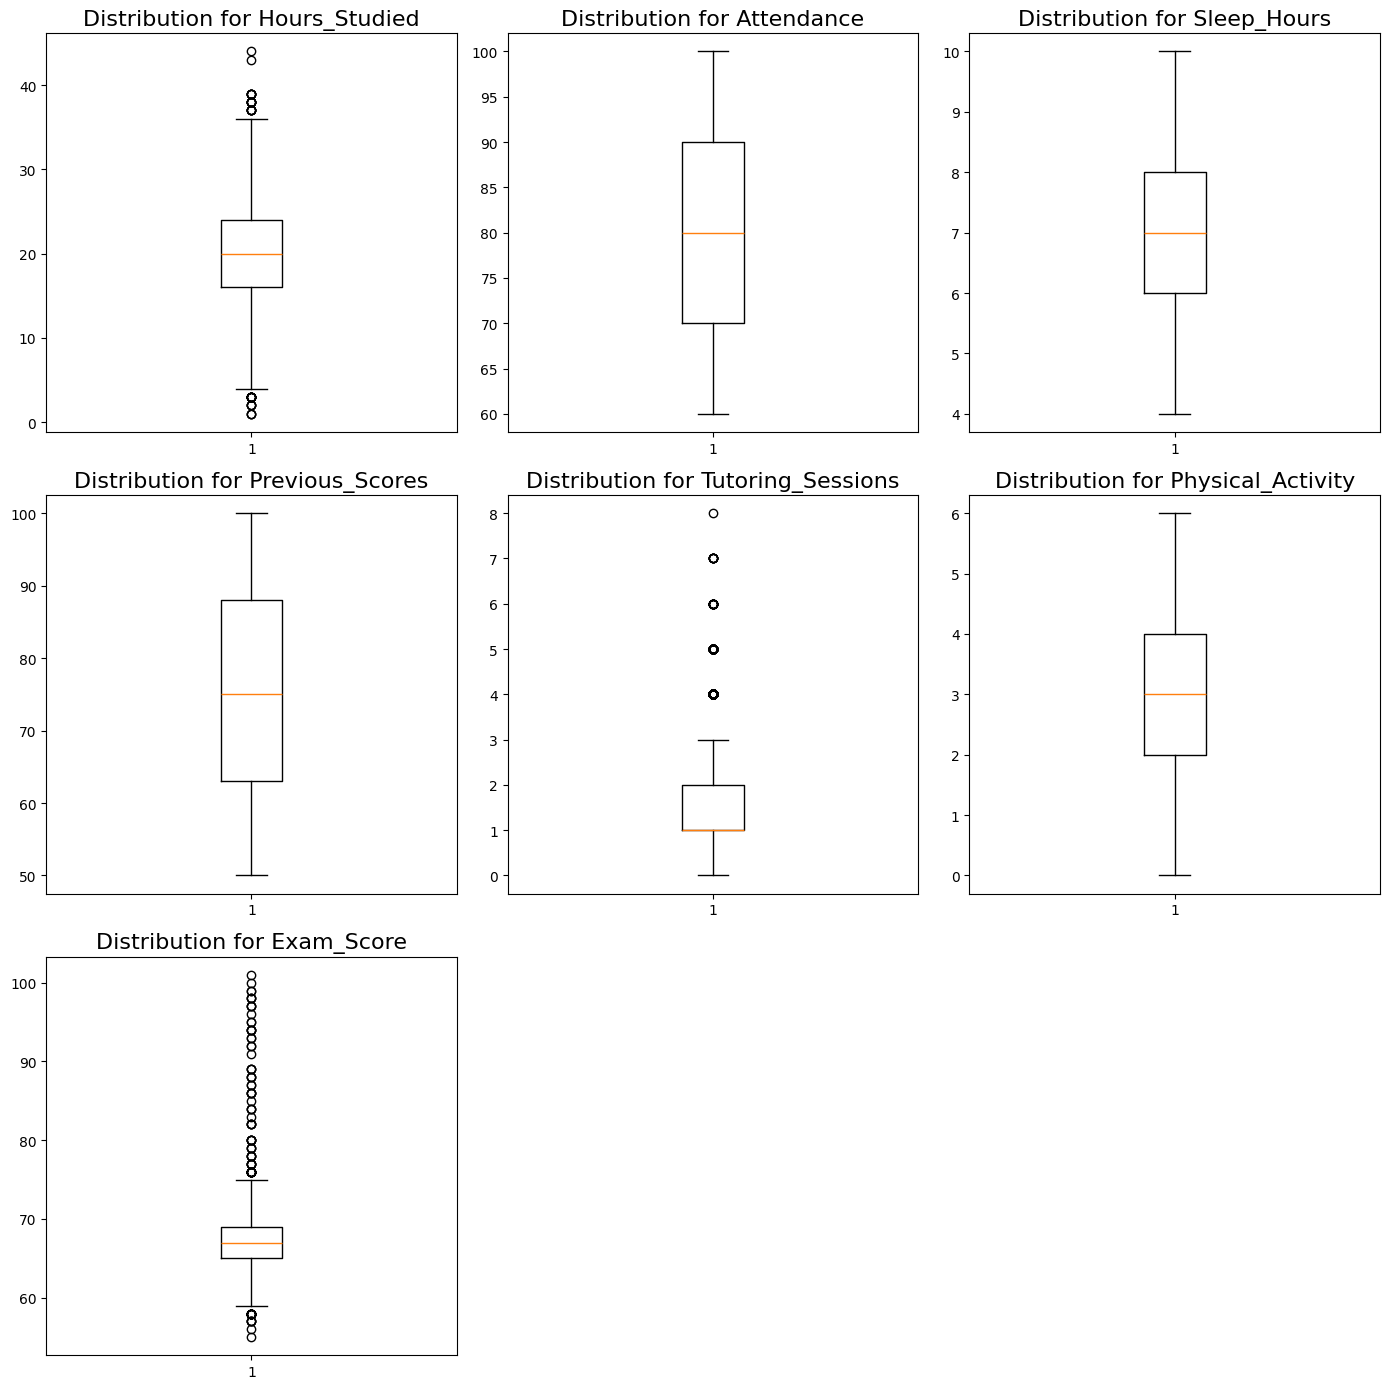

In [305]:
fig = plt.figure(figsize=(14, 14))
gs = gridspec.GridSpec(nrows=3, ncols=3)

ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2])
ax20 = fig.add_subplot(gs[2, 0])

ax = [ax00, ax01, ax02, ax10, ax11, ax12, ax20]

for i, colname in enumerate(numerical_variables):

    ax[i].boxplot(students_adjusted[colname])

    ax[i].set_title(f"Distribution for {colname}")

plt.tight_layout()
plt.show()

##### Pairwise plot

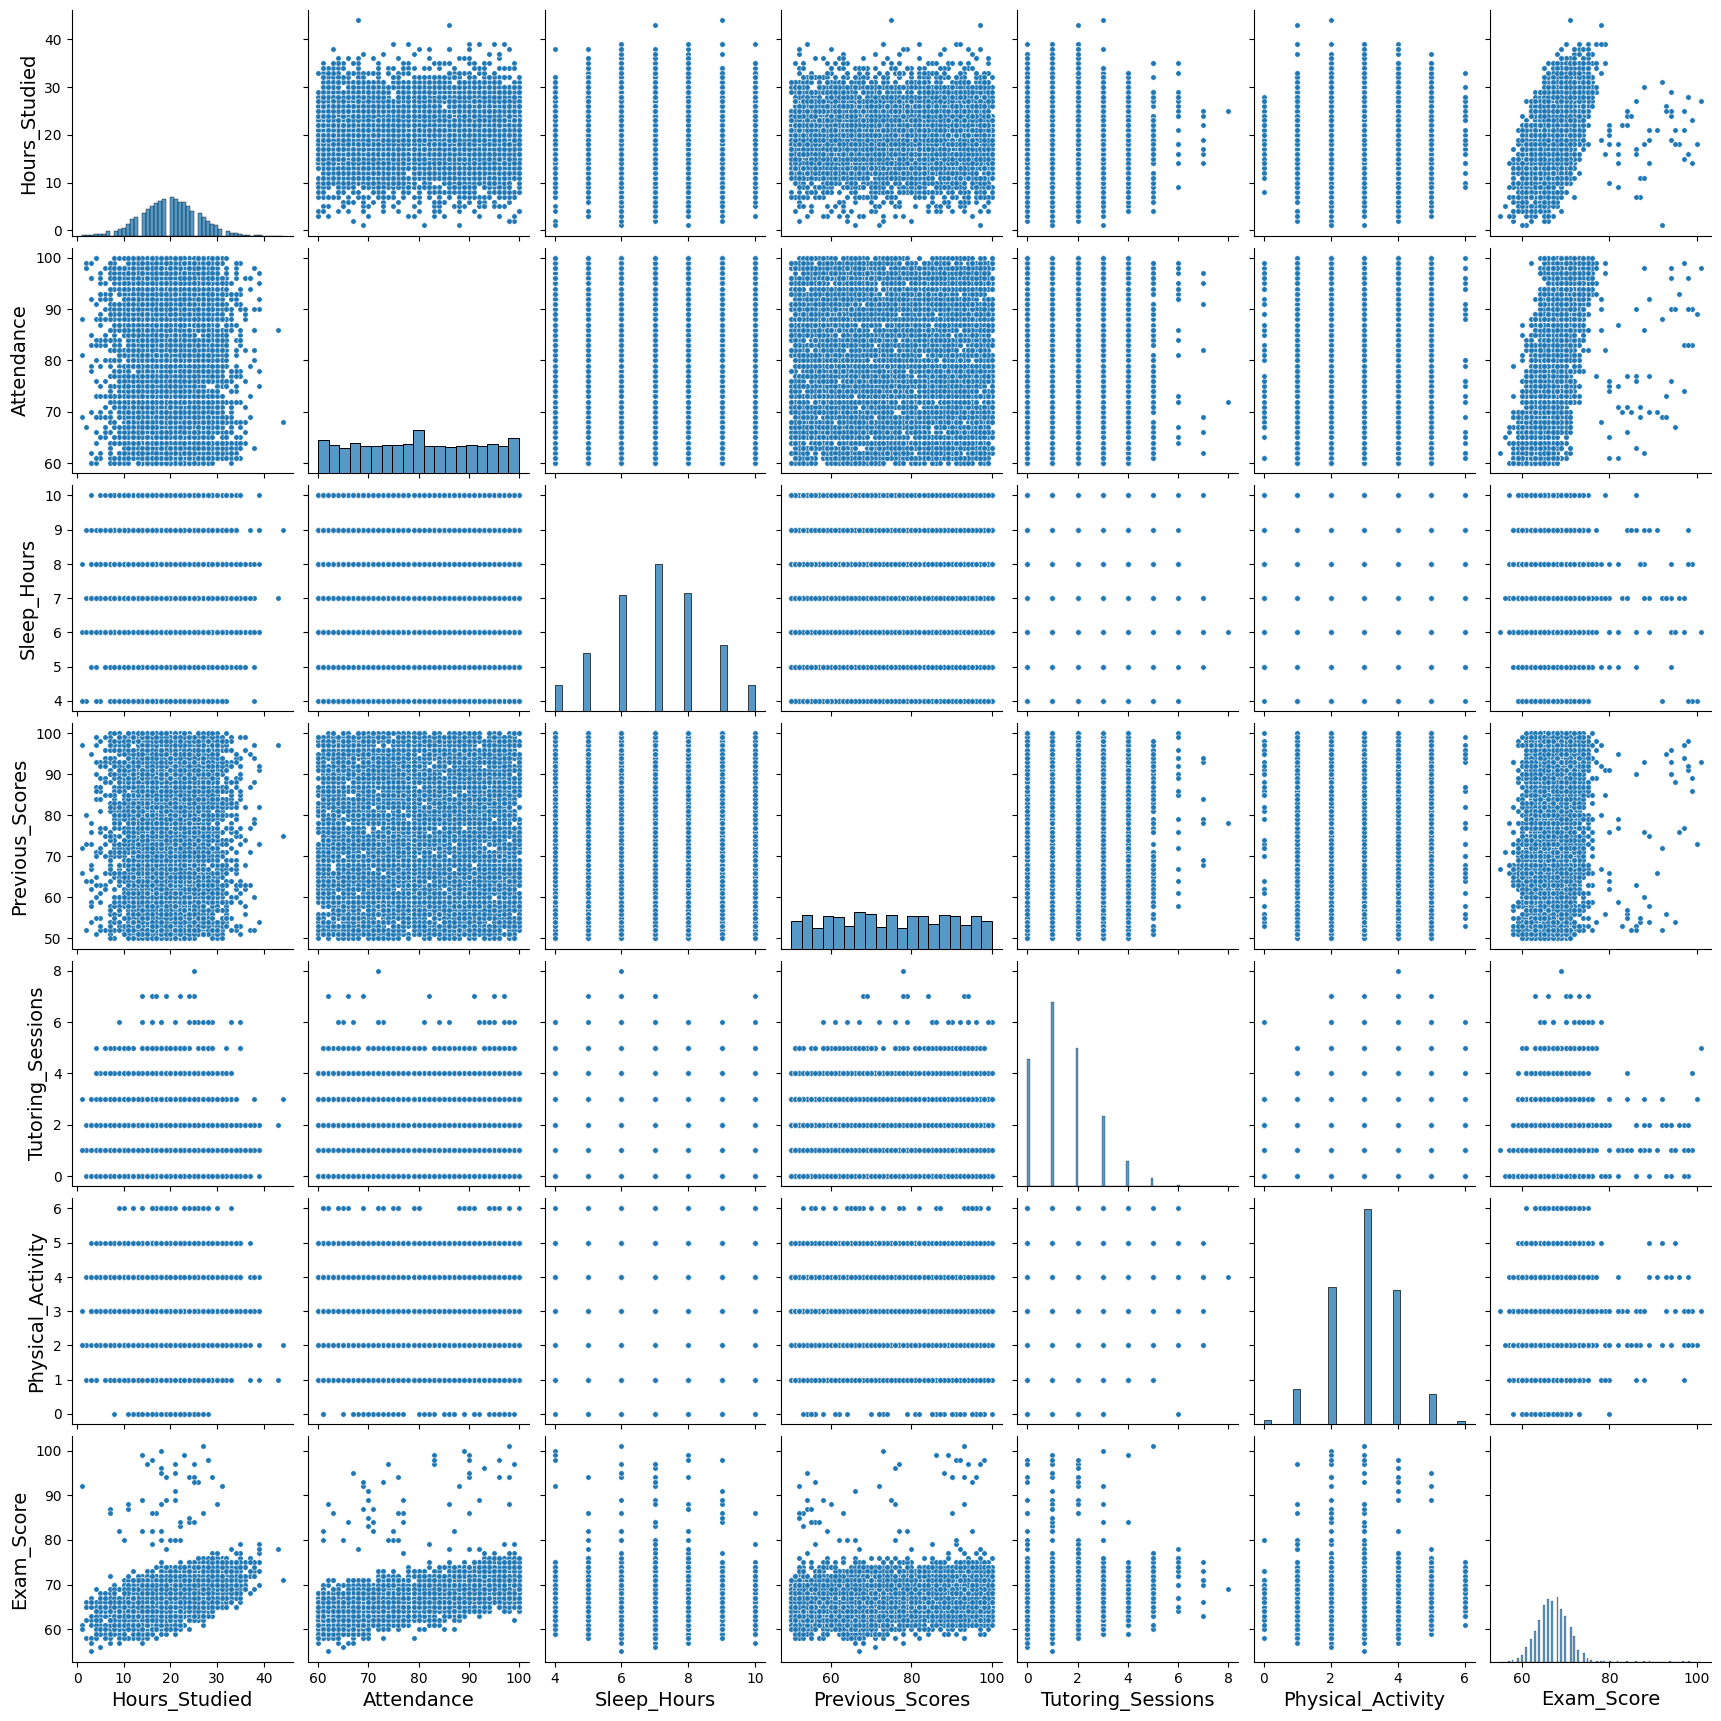

In [306]:
sns.pairplot(students_adjusted[numerical_variables], diag_kind='hist', plot_kws={'s': 15})

##### Correlation heatmap

In [307]:
student_corr = students_adjusted[numeric_cols].corr()

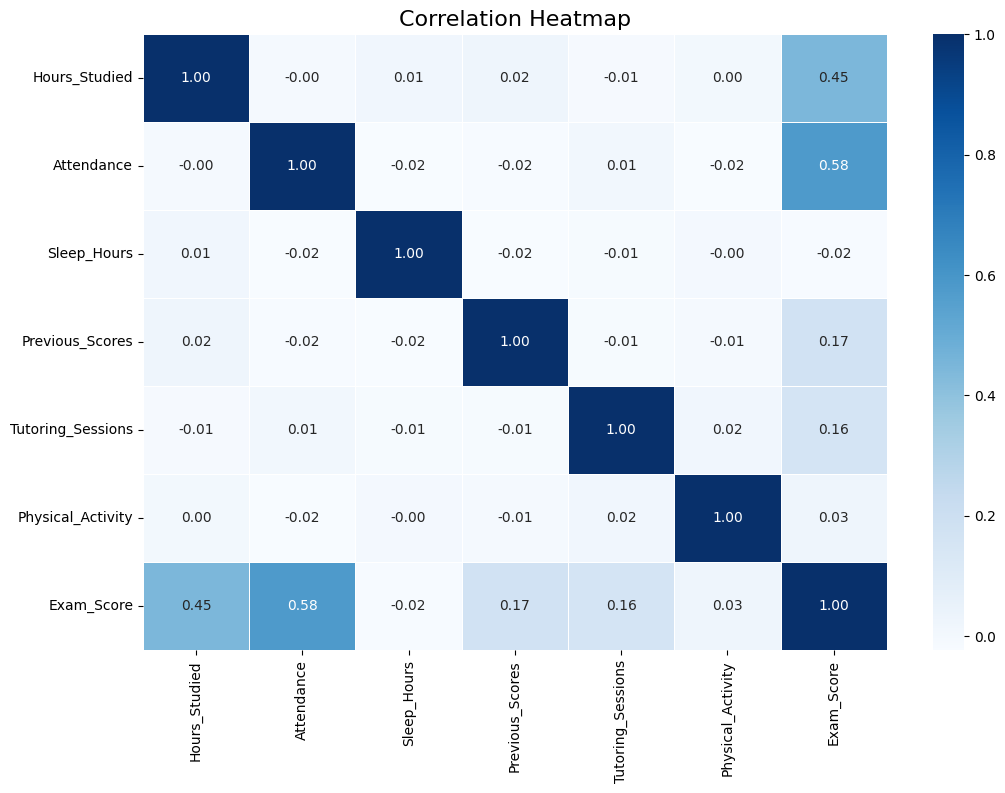

In [308]:
plt.figure()
sns.heatmap(student_corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Our hypotheses

<div class="alert alert-block alert-danger">

_To compelete..._

</div>

<div class="alert alert-block alert-success">

**Our response variable will be: <kbd>Exam_Score</kbd>**

</div>

Let's define our final dataset to perform MLR on:

In [309]:
performance = students_adjusted.copy()

In [310]:
students_adjusted.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## Initial Model

In [311]:
X = students_adjusted.drop('Exam_Score', axis=1)
y = students_adjusted['Exam_Score']

In [312]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [313]:
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


results = pd.DataFrame(columns=[
    'Predictor', 'Correlation', 'P-value', 'R-squared', 'Adj_R-squared', 'VIF', 
    'T-statistic', 'F-statistic', 'AIC', 'BIC', 
    'ANOVA_Type1_F', 'ANOVA_Type1_P', 
    'ANOVA_Type2_F', 'ANOVA_Type2_P', 
    'ANOVA_Type3_F', 'ANOVA_Type3_P'
])

In [314]:
for i, predictor in enumerate(X.columns):
    X_i = sm.add_constant(X_scaled[:, i])
    model = sm.OLS(y, X_i).fit()
    
    p_value = model.pvalues.iloc[1]
    rsq = model.rsquared
    adj_rsq = model.rsquared_adj
    t_statistic = model.tvalues.iloc[1]
    f_statistic = model.fvalue
    vif = variance_inflation_factor(X_scaled, i)
    aic = model.aic  
    bic = model.bic  
    
    correlation = pd.Series(X_scaled[:, i]).corr(y)
    
    formula = f'Exam_Score ~ {predictor}'
    model_anova = smf.ols(formula, data=students_adjusted).fit()

    anova_type1 = anova_lm(model_anova, typ=1)
    anova_type1_f = anova_type1['F'].iloc[0]
    anova_type1_p = anova_type1['PR(>F)'].iloc[0]
    
    anova_type2 = anova_lm(model_anova, typ=2)
    anova_type2_f = anova_type2['F'].iloc[0]
    anova_type2_p = anova_type2['PR(>F)'].iloc[0]
    
    anova_type3 = anova_lm(model_anova, typ=3)
    anova_type3_f = anova_type3['F'].iloc[0]
    anova_type3_p = anova_type3['PR(>F)'].iloc[0]
    
    current_results = pd.DataFrame({
        'Predictor': [predictor],
        'Correlation': [correlation],  # Correlation in the second column
        'P-value': [p_value],
        'R-squared': [rsq],
        'Adj_R-squared': [adj_rsq],
        'VIF': [vif],
        'T-statistic': [t_statistic],
        'F-statistic': [f_statistic],
        'AIC': [aic],
        'BIC': [bic],
        'ANOVA_Type1_F': [anova_type1_f],
        'ANOVA_Type1_P': [anova_type1_p],
        'ANOVA_Type2_F': [anova_type2_f],
        'ANOVA_Type2_P': [anova_type2_p],
        'ANOVA_Type3_F': [anova_type3_f],
        'ANOVA_Type3_P': [anova_type3_p]
    })

    current_results = current_results.dropna(how='all', axis=1)
    results = pd.concat([results, current_results], ignore_index=True)

results_sorted = results.sort_values(by='Adj_R-squared', ascending=False)
results_sorted

C:\Users\chely\AppData\Local\Temp\ipykernel_28852\3609911391.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, current_results], ignore_index=True)


,Predictor,Correlation,P-value,R-squared,Adj_R-squared,VIF,T-statistic,F-statistic,AIC,BIC,ANOVA_Type1_F,ANOVA_Type1_P,ANOVA_Type2_F,ANOVA_Type2_P,ANOVA_Type3_F,ANOVA_Type3_P
1,Attendance,0.003104,0.000000e+00,0.336700,0.336596,1.003434,56.890623,3236.542960,32891.664424,32905.185643,3236.542960,0.000000e+00,3236.542960,0.000000e+00,3.398701e+04,0.0
0,Hours_Studied,0.003507,4.524802e-308,0.198118,0.197992,1.002271,39.689943,1575.291562,34101.790605,34115.311825,1575.291562,4.524802e-308,1575.291562,4.524802e-308,1.613659e+05,0.0
6,Previous_Scores,0.019833,1.121433e-44,0.030375,0.030223,1.003842,14.132771,199.735203,35313.278862,35326.800082,199.735203,1.121433e-44,199.735203,1.121433e-44,6.180827e+04,0.0
9,Tutoring_Sessions,0.002661,2.102216e-36,0.024595,0.024442,1.001632,12.679697,160.774705,35351.180193,35364.701412,160.774705,2.102216e-36,160.774705,2.102216e-36,7.646139e+05,0.0
13,Peer_Influence,0.008092,2.105122e-15,0.009827,0.009672,1.002203,7.954933,63.280966,35447.022378,35460.543598,32.180333,1.242613e-14,32.180333,1.242613e-14,3.886075e+05,0.0
2,Parental_Involvement,0.007785,5.259722e-14,0.008843,0.008688,1.002094,-7.542343,56.886934,35453.358706,35466.879926,80.462228,3.086485e-35,80.462228,3.086485e-35,5.698013e+05,0.0
3,Access_to_Resources,0.000353,1.446812e-12,0.007830,0.007675,1.003961,-7.093709,50.320703,35459.872237,35473.393457,92.416360,2.722170e-40,92.416360,2.722170e-40,5.916635e+05,0.0
17,Distance_from_Home,-0.005317,1.830671e-12,0.007759,0.007603,1.002023,7.060830,49.855316,35460.334142,35473.855361,24.936704,1.630308e-11,24.936704,1.630308e-11,1.849432e+05,0.0
15,Learning_Disabilities,-0.005272,1.921126e-11,0.007041,0.006885,1.002373,-6.724033,45.212618,35464.943930,35478.465150,45.212618,1.921126e-11,45.212618,1.921126e-11,1.702976e+06,0.0
4,Extracurricular_Activities,0.013779,4.646554e-07,0.003977,0.003821,1.001554,5.045584,25.457916,35484.595934,35498.117154,25.457916,4.646554e-07,25.457916,4.646554e-07,7.550905e+05,0.0


After looking at the $R^2_{a}$ of exam score regressed onto each individual predictor, we're going to naively choose the 6 predictors with the strongest $R^2_{a}$ values to model.

In [315]:
selected_predictors = [
    'Attendance', 
    'Hours_Studied', 
    'Previous_Scores', 
    'Tutoring_Sessions', 
    'Peer_Influence', 
    'Parental_Involvement'
]

categorical_predictors = ['Peer_Influence', 'Parental_Involvement']

X = students_adjusted[selected_predictors]
y = students_adjusted['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

le = LabelEncoder()
for col in categorical_predictors:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = sm.add_constant(X_train_scaled)  
model = sm.OLS(y_train, X_train_scaled).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     1117.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        04:26:43   Log-Likelihood:                -10378.
No. Observations:                4464   AIC:                         2.077e+04
Df Residuals:                    4457   BIC:                         2.081e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.2581      0.037   1815.017      0.0

Since the model has a moderate $R^2_{a}$ value, we want to look at the residuals to ensure that none of the model assumptions were violated. 

In [316]:
X_test_scaled = sm.add_constant(X_test_scaled)  
y_pred = model.predict(X_test_scaled)

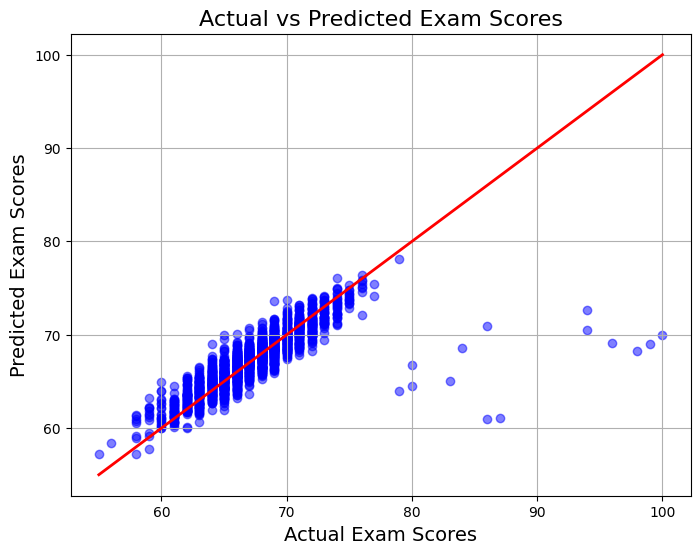

In [317]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Exam Scores')
plt.title('Actual vs Predicted Exam Scores')
plt.grid(True)
plt.show()

There are some points that don't align with the rest of the distribution and might be influential points. 

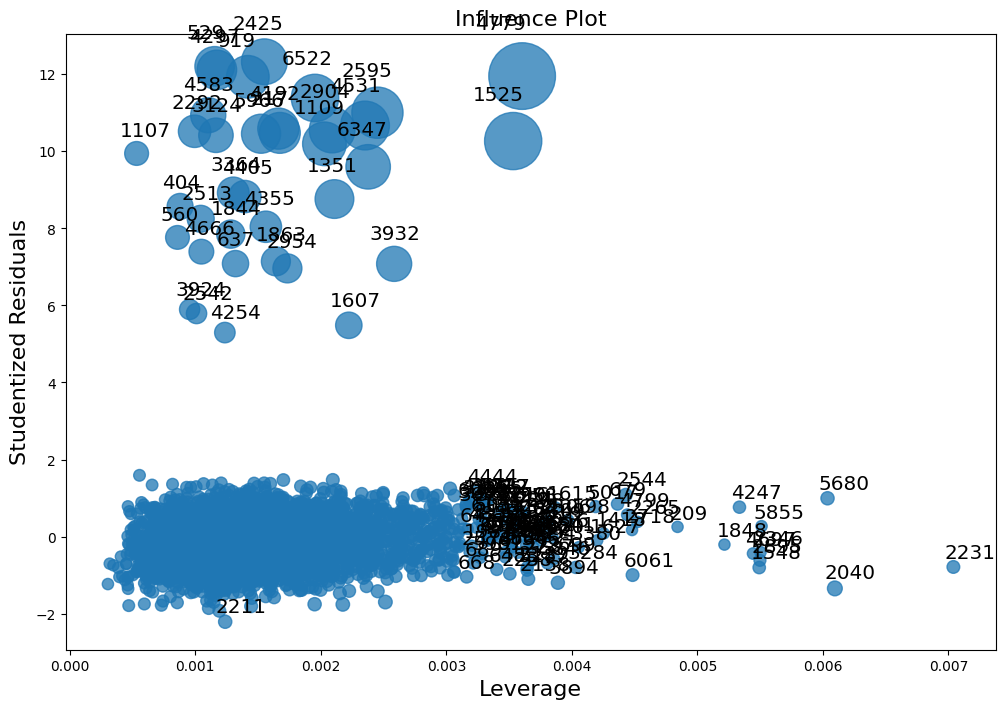

In [318]:
fig, ax = plt.subplots()
influence_plot(model, ax=ax, criterion="cooks")
plt.show()

There are a significant number of influential points so we're going to do some transformations on the data.

## Box-Cox Transformation

In [319]:
le = LabelEncoder()
for col in categorical_predictors:
    X.loc[:, col] = le.fit_transform(X[col]) 

X_boxcox = X.apply(lambda x: stats.boxcox(x + 1)[0]) 
y_boxcox, fitted_lambda = stats.boxcox(y + 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_boxcox)

X_const = sm.add_constant(X_scaled)
model_boxcox = sm.OLS(y_boxcox, X_const).fit()
print("Box-Cox Transformation Model Summary")
print(f"Lambda used for Box-Cox Transformation: {fitted_lambda}")
print(model_boxcox.summary())


C:\Users\chely\AppData\Local\Temp\ipykernel_28852\2231151566.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 0 1 ... 0 2 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = le.fit_transform(X[col])
C:\Users\chely\AppData\Local\Temp\ipykernel_28852\2231151566.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 2 ... 2 0 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = le.fit_transform(X[col])


Box-Cox Transformation Model Summary
Lambda used for Box-Cox Transformation: -2.680694363675312
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     2814.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        04:26:57   Log-Likelihood:                 85921.
No. Observations:                6378   AIC:                        -1.718e+05
Df Residuals:                    6371   BIC:                        -1.718e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

The $R^2$has improved so now we'll see how the residuals have changed. 

In [320]:
y_pred_boxcox = model_boxcox.predict(X_const)
residuals = y_boxcox - y_pred_boxcox

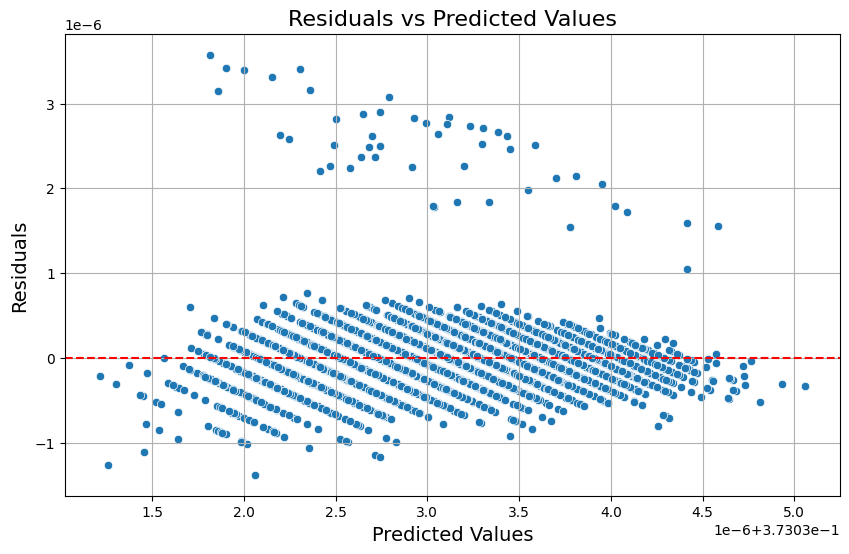

In [321]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_boxcox, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

There still seems to be a significant amount of data that's falling outside the expected bounds of the data so we'll try including more predictors and splitting the data into multiple models.

## Lasso Model Selection

In [322]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

NameError: name 'ColumnTransformer' is not defined